<a href="https://colab.research.google.com/github/wilberquito/Thesis/blob/main/Code/nn/MelanomaClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma classifier with Pytorch


In [2]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
In colab: True


In [2]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code() 

Unzipping the code from google drive


In [2]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data() 

You sure? Y/n
Y
Unzipping the data from google drive


## Load data using source code

In [4]:
import modular.dataset as m_dataset

In [ ]:
data_dir = 'data.etl'
data_folder = '512'

train_df, test_df, mapping = m_dataset.get_df(data_dir,
                                              data_folder)

In [ ]:
train_df.shape, test_df.shape, mapping

((31265, 13),
 (10982, 9),
 {'AK': 0,
  'BCC': 1,
  'BKL': 2,
  'DF': 3,
  'SCC': 4,
  'VASC': 5,
  'melanoma': 6,
  'nevus': 7})

In [ ]:
train_df.tail()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath
31260,25267,ISIC_0073247,-1,female,85.0,head/neck,BCC,benign,1,19,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0073...
31261,25268,ISIC_0073248,-1,male,65.0,anterior torso,BKL,benign,2,7,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0073...
31262,25269,ISIC_0073249,-1,male,70.0,lower extremity,melanoma,malignant,6,9,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0073...
31263,25270,ISIC_0073251,-1,female,55.0,palms/soles,nevus,benign,7,15,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0073...
31264,25271,ISIC_0073254,-1,male,50.0,upper extremity,BKL,benign,2,23,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0073...


In [ ]:
test_df.head()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,filepath
0,0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00520...
1,1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00523...
2,2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00585...
3,3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00733...
4,4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080,data.etl/jpeg-melanoma-512x512/test/ISIC_00735...


In [ ]:
pd.DataFrame(mapping, index=mapping.values()).head(1)

,AK,BCC,BKL,DF,SCC,VASC,melanoma,nevus
0,0,1,2,3,4,5,6,7


In [ ]:
dict(sorted(train_df.set_index('target')['diagnosis'].items()))

{0: 'AK',
 1: 'BCC',
 2: 'BKL',
 3: 'DF',
 4: 'SCC',
 5: 'VASC',
 6: 'melanoma',
 7: 'nevus'}

## Create dataloader from csv

In [ ]:
import modular.dataset as m_dataset
melanoma_dataset = m_dataset.MelanomaDataset(train_df,
                                             mode='train')
train_dataset, val_datasaet                                             

In [ ]:
from sklearn.model_selection import train_test_split

def train_validate_split(df: pd.DataFrame,
                         random_state: int = 42,
                         validate_size: int = 0.25):
    """Split dataframe into random train and validate dataframe"""

    X_train, X_val = train_test_split(df,
                                      random_state=random_state,
                                      train_size=(1-validate_size))
    X_train = pd.DataFrame(X_train)
    X_train.columns = df.columns
    X_val = pd.DataFrame(X_val)
    X_val.columns = df.columns

    return X_train, X_val


data_dir = 'data.etl'
data_folder = '512'

train_df, test_df, mapping = m_dataset.get_df(data_dir,
                                              data_folder)
print(train_df.shape)                                              
idx_to_class = { i : classname for classname, i in mapping.items() }

train_df, val_df = train_validate_split(train_df,
                                            random_state=42,
                                            validate_size=0.15)

print(train_df.shape, val_df.shape)

(31265, 13)
(26575, 13) (4690, 13)


In [ ]:
train_df.head()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath
10114,4121,ISIC_0025550,-1,female,80.0,lower extremity,melanoma,malignant,6,16,600,450,data.etl/jpeg-isic2019-512x512/train/ISIC_0025...
2752,2752,ISIC_4632020,IP_7145044,female,65.0,lower extremity,nevus,benign,7,3,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_4632...
14192,8199,ISIC_0029646,-1,female,20.0,posterior torso,nevus,benign,7,18,600,450,data.etl/jpeg-isic2019-512x512/train/ISIC_0029...
3885,3885,ISIC_6475049,IP_3780490,female,35.0,lower extremity,nevus,benign,7,7,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_6475...
4972,4972,ISIC_8263489,IP_9111321,male,60.0,torso,melanoma,malignant,6,8,6000,4000,data.etl/jpeg-melanoma-512x512/train/ISIC_8263...


In [ ]:
val_df.head()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath
28009,22016,ISIC_0068116,-1,male,50.0,head/neck,melanoma,malignant,6,19,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0068...
14748,8755,ISIC_0030204,-1,male,35.0,posterior torso,nevus,benign,7,16,600,450,data.etl/jpeg-isic2019-512x512/train/ISIC_0030...
29081,23088,ISIC_0069772,-1,female,80.0,lower extremity,AK,benign,0,3,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0069...
16926,10933,ISIC_0032392,-1,male,65.0,anterior torso,nevus,benign,7,28,600,450,data.etl/jpeg-isic2019-512x512/train/ISIC_0032...
21529,15536,ISIC_0057806,-1,female,65.0,head/neck,AK,benign,0,27,1024,1024,data.etl/jpeg-isic2019-512x512/train/ISIC_0057...


In [ ]:
from torch.utils.data import DataLoader

# Compute the mapping class
idx_to_class = { i : classname for classname, i in mapping.items() }

# Split dataframe into train and validate

# Create train and validate dataset
melanoma_dataset = m_dataset.MelanomaDataset(train_df,
                                             mode='train',
                                             idx_to_class=idx_to_class)
melanoma_dataloader = DataLoader(melanoma_dataset, batch_size=64, shuffle=True)
melanoma_dataloader

For display purposes, n shouldn't
        be larger than 10, setting to 10 and removing shape display.


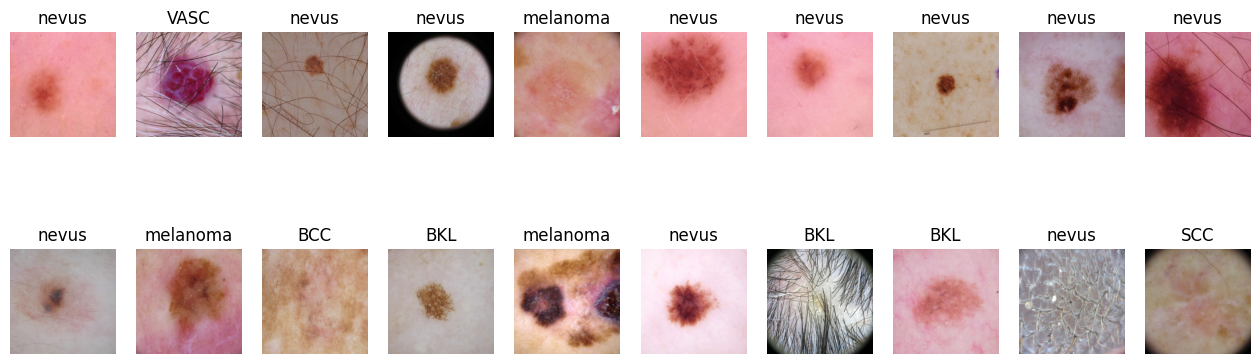

In [ ]:
import modular.utility as m_utility
m_utility.display_random_images(melanoma_dataset, n=20, display_shape=False)

## Exploratory data analysis

In [ ]:
train_df.head()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath
0,0,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,7,6,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_0052...
1,1,ISIC_0076995,IP_2235340,female,55.0,torso,nevus,benign,7,10,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_0076...
2,2,ISIC_0084086,IP_4023055,male,60.0,lower extremity,nevus,benign,7,12,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_0084...
3,3,ISIC_0084270,IP_2961528,male,40.0,lower extremity,nevus,benign,7,1,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_0084...
4,4,ISIC_0084395,IP_0175539,female,45.0,torso,nevus,benign,7,3,1872,1053,data.etl/jpeg-melanoma-512x512/train/ISIC_0084...


In [ ]:
test_df.head()

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,filepath
0,0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00520...
1,1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00523...
2,2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00585...
3,3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000,data.etl/jpeg-melanoma-512x512/test/ISIC_00733...
4,4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080,data.etl/jpeg-melanoma-512x512/test/ISIC_00735...


In [ ]:
train_df.shape, test_df.shape

((31265, 13), (10982, 9))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31265 entries, 0 to 31264
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     31265 non-null  int64  
 1   image_name                     31265 non-null  object 
 2   patient_id                     31265 non-null  object 
 3   sex                            31265 non-null  object 
 4   age_approx                     30825 non-null  float64
 5   anatom_site_general_challenge  28591 non-null  object 
 6   diagnosis                      31265 non-null  object 
 7   benign_malignant               31265 non-null  object 
 8   target                         31265 non-null  int64  
 9   tfrecord                       31265 non-null  int64  
 10  width                          31265 non-null  int64  
 11  height                         31265 non-null  int64  
 12  filepath                       31265 non-null 

In [ ]:
train_df.describe()

,Unnamed: 0,age_approx,target,tfrecord,width,height
count,31265.000000,30825.000000,31265.000000,31265.000000,31265.000000,31265.000000
mean,10787.762162,53.445418,5.445226,13.040844,1133.792004,891.995938
std,7615.350726,17.332589,2.351857,8.523935,749.065866,500.673148
min,0.000000,0.000000,0.000000,0.000000,576.000000,450.000000
25%,3908.000000,40.000000,4.000000,6.000000,600.000000,450.000000
50%,9639.000000,55.000000,7.000000,12.000000,1024.000000,1024.000000
75%,17455.000000,65.000000,7.000000,20.000000,1024.000000,1024.000000
max,25271.000000,90.000000,7.000000,29.000000,6000.000000,5184.000000


## Diagnosis

Here I notice that I have an unbalanced data set of 8 classes

In [ ]:
diagnosis_freq = train_df['diagnosis'].value_counts()
diagnosis_freq

nevus       18031
melanoma     5090
BCC          3320
BKL          2837
AK            867
SCC           628
VASC          253
DF            239
Name: diagnosis, dtype: int64

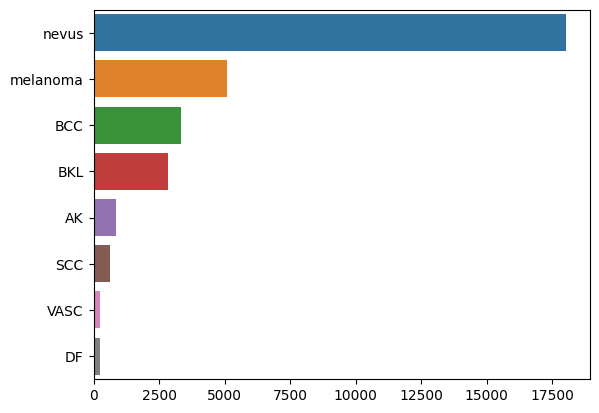

In [ ]:
_ = sns.barplot(x=diagnosis_freq.values, y=diagnosis_freq.index)

## Diagnosis and Melanoma

Clearly, when it's a malignant cancer if only if diagnosis is labeled as `MEL`, which is melanoma.

In [ ]:
tmp =  train_df.groupby(by=['diagnosis', 'benign_malignant'], 
           as_index=False).count()

pivot_table = tmp.pivot(index='diagnosis', columns='benign_malignant', values='sex')
pivot_table = pivot_table.fillna(0)
pivot_table

benign_malignant,benign,malignant
diagnosis,,
AK,867.0,0.0
BCC,3320.0,0.0
BKL,2837.0,0.0
DF,239.0,0.0
SCC,628.0,0.0
VASC,253.0,0.0
melanoma,0.0,5090.0
nevus,18031.0,0.0


## Fine tunning

In [4]:
!nvidia-smi

Thu May 18 11:06:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Show dataloaders content


# for batch_idx, (inputs, labels) in enumerate(train_dataloader):
#      print(batch_idx, inputs.shape, labels.shape)

#for batch_idx, (inputs, labels) in enumerate(validate_dataloader):
#      print(batch_idx, inputs.shape, labels.shape)

#for batch_idx, inputs in enumerate(test_dataloader):
#  print(batch_idx, inputs[0].shape)

In [3]:
def writter(log: dict):
  print('Logging...')
  print(log.keys())

In [4]:
from torchvision.models import (ResNet18_Weights)
transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
## Try a Resnet prediction
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import modular.engine as engine
from torchvision.models import (ResNet18_Weights)
from torch.utils.data import DataLoader
import torch
import modular.dataset as m_dataset
from torchvision import transforms

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, test_df, mapping = m_dataset.get_df(data_dir, data_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(mapping))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.15)


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validate_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = m_dataset.MelanomaDataset(train_df,
                                          mode='train',
                                          transform=train_transform,
                                          idx_to_class=idx_to_class)                                                       
validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transform=validate_transform,
                                             idx_to_class=idx_to_class)                                                       

batch_size = 512                                             

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and dataloader
test_dataset = m_dataset.MelanomaDataset(test_df,
                                         mode='test',
                                         idx_to_class=idx_to_class)                                                       
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders
train_dataloaders = {
    'train': train_dataloader,
    'val': validate_dataloader,
}

train_dataloaders_size = {
    'train': len(train_dataset),
    'val': len(validate_dataset),
}

model_ft = engine.train_model(model_ft, 
                              train_dataloaders,
                              train_dataloaders_size,
                              device,
                              criterion, 
                              optimizer_ft, 
                              exp_lr_scheduler,
                              num_epochs=25,
                              writter=writter)

Epoch 1/25
----------
train Loss: 1.1379 Acc: 0.6052
val Loss: 0.9365 Acc: 0.6748
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best_model_wts'])
Epoch 2/25
----------
train Loss: 0.8880 Acc: 0.6863
val Loss: 0.8515 Acc: 0.7045
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best_model_wts'])
Epoch 3/25
----------
train Loss: 0.8149 Acc: 0.7097
val Loss: 0.8076 Acc: 0.7145
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best_model_wts'])
Epoch 4/25
----------
train Loss: 0.7681 Acc: 0.7252
val Loss: 0.7829 Acc: 0.7196
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best_model_wts'])
Epoch 5/25
----------
train Loss: 0.7275 Acc: 0.7381
val Loss: 0.7553 Acc: 0.7318
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best_model_wts'])
Epoch 6/25
----------
train Loss: 0.6945 Acc: 0.7501
val Loss: 0.7357 Acc: 0.7373
Logging...
dict_keys(['results', 'epoch', 'optimizer', 'scheduler', 'best

KeyboardInterrupt: ignored

## Show the arquitecture nets

Here I show the EffNet, ResNet and ConvNext.

In [ ]:
optimizer

In [ ]:
criterion

In [ ]:
print(f'Samples to train {len(train_loader)}, Samples to test {len(test_loader)}')

In [ ]:
print('Powered by GPU' if device == 'cuda' else 'Powered by CPU')

In [ ]:
results = train(effnet_nn,
                train_loader,
                test_loader,
                optimizer,
                criterion,
                epochs,
                device)